## Part 1: feature stack creation and saving

In [1]:
# necessary packages for feature stack
import numpy as np
from scipy import ndimage

import matplotlib.pyplot as plt

from skimage import filters, feature, io
from skimage.morphology import disk,ball

# from sklearn.ensemble import RandomForestClassifier

import os
import imageio
import sys
import dask
import dask.array
# import cupy as cp
# import cucim
from itertools import combinations_with_replacement
import xarray as xr

### 1.1 feature functions

In [2]:
# functions take chunked dask-array as input


def nd_gaussian(da, sig = 0):
    if np.abs(sig-0)<0.1:
        G = np.array(da)
        fullname = 'original'
    else:
        deptharray = np.ones(da.ndim)+4*sig
        deptharray = tuple(np.min([deptharray, da.shape], axis=0))
        G = da.map_overlap(filters.gaussian, depth=deptharray, boundary='nearest', sigma = sig).compute()
        # G = da.map_overlap(filters.gaussian, depth=4*sig+1, boundary='none', sigma = sig).compute()
        fullname = ''.join(['gaussian_4D_',f'{sig:.1f}'])
    return G, fullname

def nd_gaussian_space(da, sig = 0):
    if np.abs(sig-0)<0.1:
        G = np.array(da)
        fullname = 'original'
    else:
        deptharray = np.ones(da.ndim)+4*sig
        deptharray = tuple(np.min([deptharray, da.shape], axis=0))
        G = da.map_overlap(filters.gaussian, depth=deptharray, boundary='nearest', sigma = (sig,sig,sig,0)).compute()
        # G = da.map_overlap(filters.gaussian, depth=4*sig+1, boundary='none', sigma = sig).compute()
        fullname = ''.join(['gaussian_space_',f'{sig:.1f}'])
    return G, fullname

def nd_gaussian_time(da, sig = 0):
    if np.abs(sig-0)<0.1:
        G = np.array(da)
        fullname = 'original'
    else:
        deptharray = np.ones(da.ndim)+4*sig
        deptharray = tuple(np.min([deptharray, da.shape], axis=0))
        G = da.map_overlap(filters.gaussian, depth=deptharray, boundary='nearest', sigma = (0,0,0,sig)).compute()
        # G = da.map_overlap(filters.gaussian, depth=4*sig+1, boundary='none', sigma = sig).compute()
        fullname = ''.join(['gaussian_time_',f'{sig:.1f}'])
    return G, fullname

#TODO create a class that makes the feature stacks and allows chosing suitable backends, e.g. dask, cupy, cucim etc.
def nd_gaussian_stack(da, sigmas):
    fullnames = []
    gstack = np.zeros(list(da.shape) + [len(sigmas)])
    for sig,i in zip(sigmas, range(len(sigmas))):
        gstack[...,i], name = nd_gaussian(da, sig)
        fullnames.append(name)
    return gstack, fullnames

def nd_gaussian_stack_space(da, sigmas):
    fullnames = []
    gstack = np.zeros(list(da.shape) + [len(sigmas)])
    for sig,i in zip(sigmas, range(len(sigmas))):
        gstack[...,i], name = nd_gaussian_space(da, sig)
        fullnames.append(name)
    return gstack, fullnames

def nd_gaussian_stack_time(da, sigmas):
    fullnames = []
    tgstack = np.zeros(list(da.shape) + [len(sigmas)])
    for sig,i in zip(sigmas, range(len(sigmas))):
        tgstack[...,i], name = nd_gaussian_time(da, sig)
        fullnames.append(name)
    return tgstack, fullnames

In [3]:
def nd_diff_of_gaussian(gstack, sigmas, mode='space'):
#     #creates a stack of {size} (see below)
    n = len(sigmas)
    size = int(n*(n-1)/2)
    dstack = np.zeros(list(da.shape) + [size])
    fullnames = []
    cc = 0
    for i in range(1,n):
        for j in range(i):
            dstack[...,cc] = gstack[...,i] - gstack[...,j]
            name = ''.join(['diff_of_gauss_',mode,'_',f'{sigmas[i]:.1f}','_',f'{sigmas[j]:.1f}'])
            fullnames.append(name)
            cc = cc + 1
    return dstack, fullnames

In [4]:
def ball_4d(sig):
    bnd = np.zeros((sig*2+1,sig*2+1,sig*2+1,sig*2+1), dtype = bool)
    bnd[sig,sig,sig,sig] = True
    ecd = ndimage.distance_transform_edt(~bnd)
    bnd = (ecd<sig+0.01).astype(int)
    return bnd

def nd_rank_like_filter(da, sigma, option):
    """
     input
     da - chunked das array up to 4D
     sigma - kernel size, scalar
     option, str ('minimum', 'maximum', 'median')
    """
    if da.ndim == 2:
        fp = disk(sigma)
    if da.ndim == 3:
        fp = ball(sigma)
    if da.ndim == 4:
        fp = ball_4d(sigma)
        
    if option == 'minimum':
        fun = ndimage.minimum_filter
    elif option == 'maximum':
        fun = ndimage.maximum_filter
    elif option == 'median':
        fun = ndimage.median_filter
    else:
        print(option+' not available')
    deptharray = np.ones(da.ndim)+sigma
    deptharray = tuple(np.min([deptharray, da.shape], axis=0))
    M = da.map_overlap(fun, depth=deptharray, footprint=fp).compute()
    # M = da.map_overlap(fun, depth=sigma+1, footprint=fp).compute()
    fullname = ''.join([option,'_',f'{sigma:.1f}'])
    return M, fullname

def nd_rank_like_stack(da, sigmas, option):
    fullnames = []
    mstack = np.zeros(list(da.shape) + [len(sigmas)-1])
    for sig,i in zip(sigmas[1:], range(len(sigmas)-1)):
        mstack[...,i], name = nd_rank_like_filter(da, sig, option)
        fullnames.append(name)
    return mstack, fullnames   
    

In [5]:
def nd_dynamic_rank_filter(da, sigma_3D, sigma_t, option):
    """
    same as rank filters above, but considering much larger range in time
    TODO: add clever option with dynmaic model, maybe sigmoid-fit, oscillation, inverse-sigmoid, etc.
    """
    fp_3D = ball(sigma_3D)
    fp_4D = np.zeros(list(fp_3D.shape)+[2*sigma_t], dtype=int)
    fp_4D[fp_3D>0,:] = 1
    
    if option == 'minimum':
        fun = ndimage.minimum_filter
    elif option == 'maximum':
        fun = ndimage.maximum_filter
    elif option == 'median':
        fun = ndimage.median_filter
    else:
        print(option+' not available')
    
    deptharray = np.ones(da.ndim)+sigma
    deptharray[-1] = sigma_t
    deptharray = tuple(np.min([deptharray, da.shape], axis=0))
    
    M = da.map_overlap(fun, depth=deptharray, footprint=fp).compute()
    fullname = ''.join(['dynamic_',option,'_',f'{sigma_3D:.1f}','_',f'{sigma_t:.1f}'])
    return M, fullname

def nd_dynamic_rank_like_stack(da, sigmas, option, sigma_t=20):
    fullnames = []
    mstack = np.zeros(list(da.shape) + [len(sigmas)-1])
    for sig,i in zip(sigmas[1:], range(len(sigmas)-1)):
        mstack[...,i], name = nd_dynamic_rank_filter(da, sig, sigma_t, option)
        fullnames.append(name)
    return mstack, fullnames  
        
    
    
    

In [6]:
def nd_Hessian_matrix(G):
    """
    copied from skimage.feature.hessian_matrix
    just directly using Gaussian fitered arrays and dask
    """
    
    daG = dask.array.from_array(G)
    gradients = dask.array.gradient(daG)
    axes = range(G.ndim)
    gradients = [gradients[ax0].compute() for ax0 in axes]
    H_elems = [dask.array.gradient(gradients[ax0], axis=ax1).compute() for ax0, ax1 in combinations_with_replacement(axes, 2)]
    elems = [(ax0,ax1) for ax0, ax1 in combinations_with_replacement(axes, 2)]
    return H_elems, elems, gradients

def nd_Hessian_stack(G, sigma):
    H_elems, elems, gradients = nd_Hessian_matrix(G)
    hstack = np.zeros(list(G.shape)+[len(elems)])
    gradstack = np.zeros(list(G.shape)+[len(gradients)])
    
    #TODO: this is slow, find some better numpy function
    gradnames = []
    for i in range(len(elems)):
        hstack[...,i] = H_elems[i]
    for i in range(len(gradients)):
        gradnames.append(''.join(['gradient_',str(i),'_',f'{sigma:.1f}']))
        gradstack[...,i] = gradients[i]
    
    # print('got Hessian matrices, now doing the eigs')
    # eigs = feature.hessian_matrix_eigvals(H_elems) 
 # for now ignore the eigenvalues (too computationally expensive and H_elems already contains the image curvature  

    fullnames = []
    for i,j in elems:
        fullname = ''.join(['hessian_',str(i),str(j),'_',f'{sigma:.1f}'])
        fullnames.append(fullname) 
    
    stack = np.concatenate([hstack,gradstack], axis=-1)
    fullnames = fullnames+gradnames                         
        
    return stack, fullnames

def nd_Hessian_stacks(gstack, sigmas):
    flag = True
    fullnames = []
    for (i, sigma) in zip(range(gstack.shape[-1]), sigmas):
        a, b = nd_Hessian_stack(gstack[...,i], sigma)
        asize = a.shape[-1]
        if flag:
            flag = False
            hstacks = np.zeros(list(gstack[...,-1].shape)+[len(sigmas)*asize])
        hstacks[...,i*asize:i*asize+asize] = a
        fullnames = fullnames + b
    return hstacks, fullnames

In [7]:
# come up for a "dynamic" feature in the time domain, e.g. sig-fit per pixel and per small subvolume like rank-filters
# TODO: include time-specific stacks

def nd_feature_Stack(da, sigmas, feat_select):
#     TODO: make more elegant
    
    fstack = []
    featnames = []
    
    print('apply Gaussian filters anyway')
    gstack, gnames = nd_gaussian_stack(da, sigmas)

    if feat_select['Gaussian']:
        featnames = featnames + gnames
        fstack.append(gstack)
        
        print('space gaussians')
        sgstack, sgnames = nd_gaussian_stack_space(da, sigmas)
        featnames = featnames + sgnames
        fstack.append(sgstack)
        
        print('time gaussians')
        tgstack, tgnames = nd_gaussian_stack_time(da, sigmas)
        featnames = featnames + tgnames
        fstack.append(tgstack)
        
    if feat_select['Hessian']:
        print('get Hessian matrices')
        hstack, hnames = nd_Hessian_stacks(gstack, sigmas)
        featnames = featnames + hnames 
        fstack.append(hstack)
        
    if feat_select['Diff of Gaussians']:
        print('get differences of Gaussians')
        dstack, dnames = nd_diff_of_gaussian(gstack, sigmas)
        featnames = featnames + dnames
        fstack.append(dstack)
        
        print('space gaussians')
        dsstack, dsnames = nd_diff_of_gaussian(sgstack, sigmas)
        featnames = featnames + dsnames
        fstack.append(dsstack) 
        
        print('time gaussians')
        dtstack, dtnames = nd_diff_of_gaussian(tgstack, sigmas)
        featnames = featnames + dtnames
        fstack.append(dtstack)
        
    if feat_select['maximum']:
        print('apply maximum filters')
        maxstack, maxnames = nd_rank_like_stack(da, sigmas, option='maximum')
        featnames = featnames + maxnames
        fstack.append(maxstack)
        
    if feat_select['median']:
        print('apply median filters')
        medstack, mednames = nd_rank_like_stack(da, sigmas, option='median')
        featnames = featnames + mednames
        fstack.append(medstack)
        
    if feat_select['minimum']:
        print('apply minimum filters')
        minstack, minnames = nd_rank_like_stack(da, sigmas, option='minimum')
        featnames = featnames + minnames
        fstack.append(minstack)
        
    if feat_select['extra_time_ranks']:
        print('do rank filters with extension in time')
        tmaxstack, tmaxnames = nd_dynamic_rank_like_stack(da, sigmas, option='maximum')
        featnames = featnames + tmaxnames
        fstack.append(tmaxstack)
        
        tminstack, tminnames = nd_dynamic_rank_like_stack(da, sigmas, option='minimum')
        featnames = featnames + tminnames
        fstack.append(tminstack)
        
        tmedstack, tmednames = nd_dynamic_rank_like_stack(da, sigmas, option='median')
        featnames = featnames + tmednames
        fstack.append(tmedstack)
        
    return np.concatenate(fstack, axis=-1), featnames

def feat_stack_to_nc(fstack, featnames, path = None):
    #TODO: include metadata and make general, now only 4D possible
    data = xr.Dataset({'feature_stack': (['x','y','z','time', 'feature'], fstack)},
                       coords = {'x': np.arange(fstack.shape[0]),
                                 'y': np.arange(fstack.shape[1]),
                                 'z': np.arange(fstack.shape[2]),
                                 'time': np.arange(fstack.shape[3]),
                                 'feature': featnames}
                      # attrs = feat_select)
                     )
    # data.attrs['name'] = name
    if path is not None:
        data.to_netcdf(path)
    return data
    

### 1.2 load 4D dataset into dask-array TODO: employ datastreaming for datasets that are too large

In [8]:
#TODO
da = None


In [9]:
## load some yarn data
# rawdata = xr.load_dataset('/home/fische_r/NAS/testing/Robert_TOMCAT_4/tomodata.nc')
raw_data = xr.load_dataset('/mpc/homes/fische_r/wood/wood_tomo.nc')

In [10]:
da = dask.array.from_array(raw_data['tomo'][30:-50,50:-50,:80,5:60].data, chunks= '30 MiB')

In [11]:
da

dask.array<array, shape=(220, 150, 80, 55), dtype=uint16, chunksize=(55, 50, 40, 55), chunktype=numpy.ndarray>

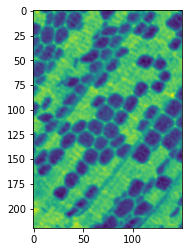

In [12]:
plt.imshow(da[:,:,30,40])

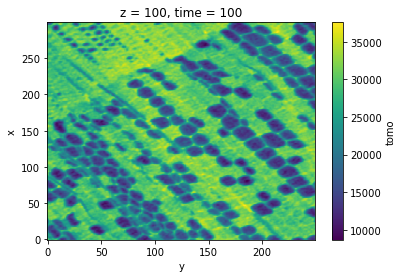

In [13]:
raw_data['tomo'].sel(z=100, time = 100).plot()

### 1.3 feature settings

In [14]:
sigmas = [0, 2,4]#, 8]  #hard-coded for now, sobel and hessian require that first sigma is 0, diff, gaussian(sig=0) = 0

# default feature choice
feat_select = {'Gaussian': True, 
               # 'Sobel': True,
               'Hessian': True,
               'Diff of Gaussians': True,
               'maximum': True,
               'minimum': True,
               'median': True,
               'extra_time_ranks': True
               
              }

In [15]:
training_dict = {}

### 1.4 Create and store feature stack

In [16]:
#output path
outpath = '/mpc/homes/fische_r/wood/feat_stack.nc'

In [ ]:
#this may take a while depending on the size and system
# may even crash because out of memory

fstack, featnames = nd_feature_Stack(da, sigmas, feat_select)

apply Gaussian filters anyway
space gaussians
time gaussians
get Hessian matrices


In [ ]:
feat_data = feat_stack_to_nc(fstack, featnames) #, outpath

In [24]:
fstack = None
data = None

In [23]:
feat_data['feature_stack'].size/1024**3

17.78942532837391

In [26]:
da

dask.array<array, shape=(250, 185, 100, 70), dtype=uint16, chunksize=(50, 37, 50, 35), chunktype=numpy.ndarray>

## Part 2: Training the classifier

In [27]:
# necessary packages

#reload after kernel reset
import xarray as xr
import os
from skimage import io
import matplotlib.pyplot as plt
import numpy as np

#the classifier
from sklearn.ensemble import RandomForestClassifier
#stuff for painting on the image
from ipywidgets import Image
from ipywidgets import ColorPicker, IntSlider, link, AppLayout, HBox
from ipycanvas import  hold_canvas,  MultiCanvas #RoughCanvas,Canvas,

### 2.1 open (not load) feature stack

In [28]:
featpath = outpath
trainingpath = '/mpc/homes/fische_r/wood'
# feat_data = xr.open_dataset(featpath)
feat_names = feat_data['feature'].data

### 2.2 training functions

In [29]:
def extract_training_data(im, truth, feat_stack):
    #pixelwise training data
    phase1 = truth==1
    phase2 = truth==2
    phase3 = truth==4   
    X1 = feat_stack[phase1]
    y1 = np.zeros(X1.shape[0])
    X2 = feat_stack[phase2]
    y2 = np.ones(X2.shape[0])
    X3 = feat_stack[phase3]
    y3 = 2*np.ones(X3.shape[0])

    y = np.concatenate([y1,y2,y3])
    X = np.concatenate([X1,X2,X3])
    
    return X,y

In [30]:
 def classify(X,y,im, feat_stack):
    # TODO: allow choice and manipulation of ML method
    clf =  RandomForestClassifier(n_estimators = 300, n_jobs=-1, random_state = 42, max_features=None) 
    clf.fit(X, y)
    num_feat = feat_stack.shape[-1]
    ypred = clf.predict(feat_stack.reshape(-1,num_feat))
    result = ypred.reshape(im.shape).astype(np.uint8)
    return result, clf

In [31]:
def training_function(im, truth, feat_stack, training_dict, slice_name):
    flag = False
    slices = list(training_dict.keys())
    if slice_name in slices: 
        slices.remove(slice_name)
    if len(slices)>0:
        flag = True
        Xall = training_dict[slices[0]][0]
        yall = training_dict[slices[0]][1]
        for i in range(1,len(slices)):
            Xall = np.concatenate([Xall, training_dict[slices[i]][0]])
            yall = np.concatenate([yall, training_dict[slices[i]][1]])
            
    X,y = extract_training_data(im, truth, feat_stack)
    
    print('training and classifying')
    
    if flag:
        Xt = np.concatenate([Xall,X])
        yt = np.concatenate([yall,y])
        Xall = None
        yall = None
    else:
        Xt = X
        yt = y  
    result, clf = classify(Xt, yt, im, feat_stack)
    
    # store training data of current slice in dict
    training_dict[slice_name] = (X,y)
    return result, clf, training_dict

### 2.3 select 2D-slice and create a training set

In [19]:
# randomly suggest slice for training
# TODO: take coordinates from feat_data
dimensions = ['x','y','z','time']

test_dims = np.random.choice(dimensions, 2, replace=False)
p1 = np.random.choice(range(len(feat_data[test_dims[0]])))
p2 = np.random.choice(range(len(feat_data[test_dims[1]])))

print('You could try ',test_dims[0],'=',p1,' and ',test_dims[1],'=',p2)
# ts = np.random.choice(range(num_ts))+1
# print('try time step ',ts )

In [617]:
#select 2D slice orthogonal to these two axes
#replace dimensions in .sel accordingly, d1c and d2c are needed for filename
#TODO: make more elegant
d1c = 'z'
d2c = 'time'
p1c = 80
p2c = 15

im = feat_data['feature_stack'].sel(z = p1c, time = p2c, feature='original').data
# im8 = np.uint8(im)
feat_stack = feat_data['feature_stack'].sel(z = p1c, time = p2c).data

In [618]:
imdry = feat_data['feature_stack'].sel(z = p1c, time = 0, feature='original').data
diff = im-imdry
diff = diff/diff.max()*255
diff[diff<0]=0
diff[diff>255] = 255

# imdry = imdry-imdry.min()
imdry = imdry/imdry.max()*255
# imdry = imdry-50
# imdry[imdry<0]=0
# imdry=imdry*255/150
# imdry[imdry>255] = 255

im8 = im-im.min()
im8 = np.uint8(im8/im8.max()*225)
# im8 = im8-50
# im8[im8<0]=0
# im8=im8*255/250
im8[im8>254] = 254
# im8old = im8.copy()

In [619]:
slice_name = ''.join([str(d1c),str(p1c),str(d2c),str(p2c)])
truthpath = os.path.join(trainingpath, ''.join(['label_image_',slice_name,'.tif']))

resultim = np.zeros(im.shape, dtype=np.uint8)
if os.path.exists(truthpath):
    truth = io.imread(truthpath)
    print('existing label set loaded')
else:
    truth = resultim.copy()

### 2.4 training interface
currently only 3 phases possible <br />
manually specify #ff000 (phase 1) #00ff00 (phase 2) or #0000ff (phase 3) as color and paint

#### 2.4.1 label data

In [632]:
width = im8.shape[1]
height = im8.shape[0]

Mcanvas = MultiCanvas(4, width=width, height=height)
background = Mcanvas[0]
resultdisplay = Mcanvas[2]
truthdisplay = Mcanvas[1]
canvas = Mcanvas[3]
canvas.sync_image_data = True

drawing = False
position = None
shape = []

def on_mouse_down(x, y):
    global drawing
    global position
    global shape

    drawing = True
    position = (x, y)
    shape = [position]

def on_mouse_move(x, y):
    global drawing
    global position
    global shape

    if not drawing:
        return

    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)

        position = (x, y)

    shape.append(position)

def on_mouse_up(x, y):
    global drawing
    global positiondu
    global shape

    drawing = False

    with hold_canvas():
        canvas.stroke_line(position[0], position[1], x, y)
        canvas.fill_polygon(shape)

    shape = []

image_data = np.stack((im8, im8, im8), axis=2)
background.put_image_data(image_data, 0, 0)

resultdisplay.global_alpha = 0.15
if np.any(resultim>0):
    result_data = np.stack((255*(resultim==0), 255*(resultim==1), 255*(resultim==2)), axis=2)
else:
    result_data = np.stack((0*resultim, 0*resultim, 0*resultim), axis=2)
resultdisplay.put_image_data(result_data, 0, 0)

canvas.on_mouse_down(on_mouse_down)
canvas.on_mouse_move(on_mouse_move)
canvas.on_mouse_up(on_mouse_up)

# canvas.stroke_style = "#749cb8"
# canvas.global_alpha = 0.75

picker = ColorPicker(description="Color:", value="#ff0000")
slidealpha = IntSlider(description="Result overlay", value=0.15)

link((picker, "value"), (canvas, "stroke_style"))
link((picker, "value"), (canvas, "fill_style"))
# link((slidealpha, "value"), (resultdisplay, "global_alpha"))

HBox((Mcanvas, picker, slidealpha))
#print('paint image with #ff0000 for air, #00ff00 for water and #0000ff for fiber')

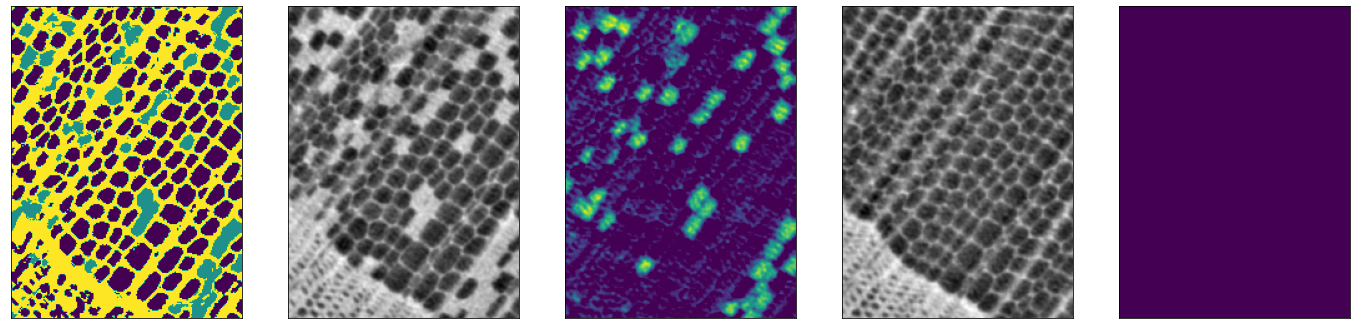

In [631]:
diff[diff<0] = 0
fig, axes = plt.subplots(1,5, figsize=(24,10))
axes[0].imshow(resultim)
axes[1].imshow(im8, 'gray')
axes[2].imshow(diff)
# axes[3].imshow(im8old, 'gray')
axes[3].imshow(imdry, 'gray')
axes[4].imshow(truth)

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

In [622]:
#create truth image from image, save to file
label_set = canvas.get_image_data()

truth[label_set[:,:,0]>0] = 1
truth[label_set[:,:,1]>0] = 2
truth[label_set[:,:,2]>0] = 4

imageio.imsave(truthpath, truth)

#### 2.4.2 actual training

In [630]:
resultim, clf, training_dict = training_function(im, truth, feat_stack, training_dict, slice_name)

training and classifying


#### 2.4.3 iterative training: go back to 2.4.1 until good segmentation or try different slice at 2.3

#### 2.4.4 plot classifier properties

/tmp/ipykernel_389238/1483009324.py:2: MatplotlibDeprecationWarning: Passing the linefmt parameter positionally is deprecated since Matplotlib 3.5; the parameter will become keyword-only two minor releases later.
  plt.stem(feat_names,clf.feature_importances_,'x')


Text(0, 0.5, 'importance')

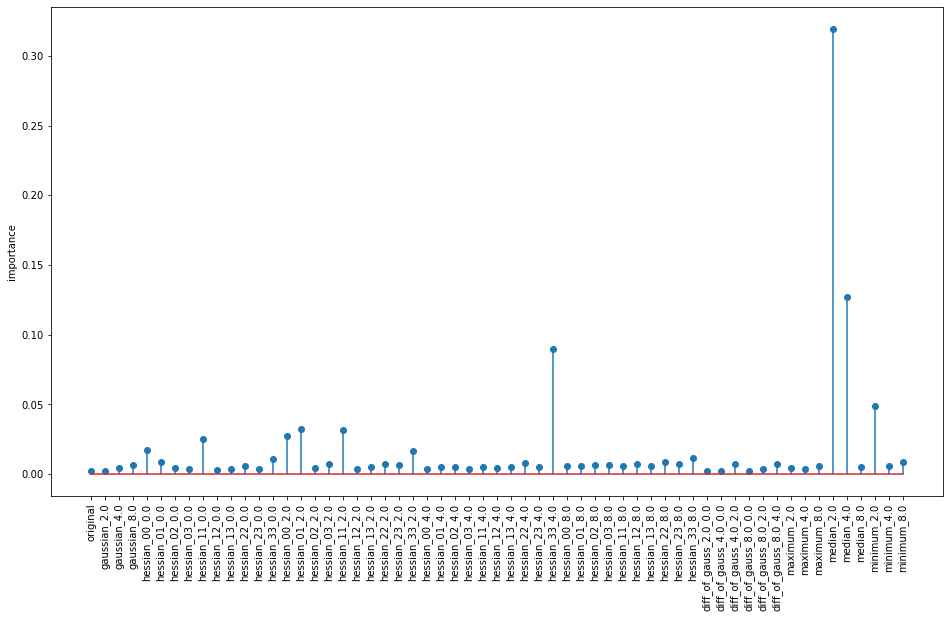

In [633]:
plt.figure( figsize=(16,9))
plt.stem(feat_names,clf.feature_importances_,'x')
plt.xticks(rotation=90)
plt.ylabel('importance')

## 3 apply classifier to full data set

In [634]:
import pickle

In [635]:
pickle.dump(clf, open(os.path.join(trainingpath, 'clf.p'),'wb'))

In [636]:
#TODO

In [637]:
def classify_all(clf, feat_stack):
    # TODO: allow choice and manipulation of ML method
    num_feat = feat_stack.shape[-1]
    ypred = clf.predict(feat_stack.reshape(-1,num_feat))
    result = ypred.reshape(feat_stack[...,0].shape).astype(np.uint8)
    return result

In [ ]:
segdata = classify_all(clf, feat_data['feature_stack'].data)

In [ ]:
segoutpath = '/home/fische_r/NAS/testing/testing/Jeremy_tomo/segmented.nc'
segdata = xr.load_dataset(segoutpath)

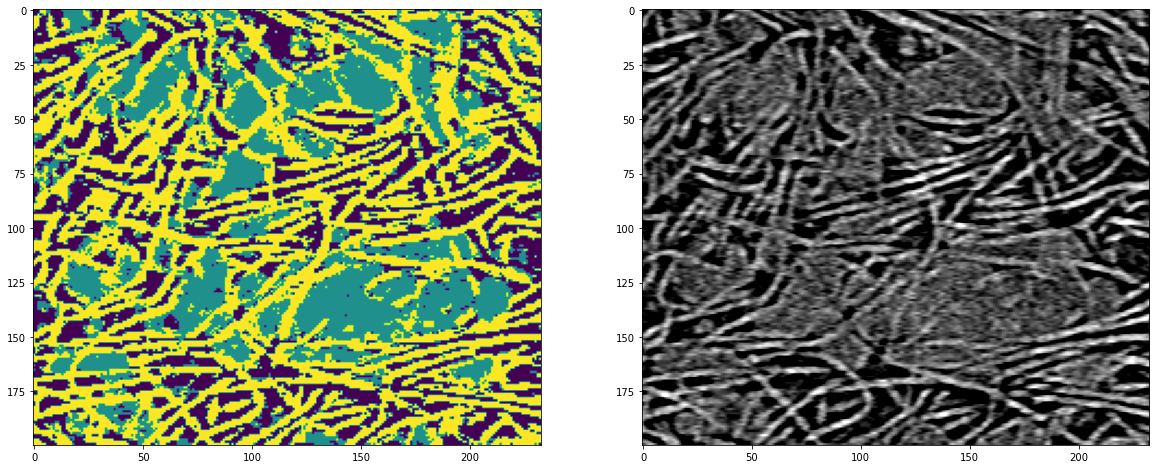

In [222]:

# y=10, t=0
xs = 0
ys = 25
ts = 6


fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(segdata['segmented'].sel(y=ys, t=ts))
axes[1].imshow(rawdata['tomo'].sel(y=ys, t=ts), cmap='gray', vmin=0,vmax=1.5e-3)